In [1]:
"""SANITY CHECK FOR:
1) LID estimation: check whether the high LID images actually look more complex
2) reconstruction loss: check the organization of batches.
"""

'SANITY CHECK FOR:\n1) LID estimation: check whether the high LID images actually look more complex\n2) reconstruction loss: check the organization of batches.\n'

In [1]:
import json
import numpy as np
import os
# add the parent directory to the Python path
import sys
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
print(sys.path)
import matplotlib.pyplot as plt
import torch

['/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python311.zip', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/lib-dynload', '', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages', '/BS/data_mani_compress/work/thesis/thesis/external/guided-diffusion', '/BS/data_mani_compress/work/thesis/thesis/external/DenseFlow', '/BS/data_mani_compress/work/thesis/thesis']


In [5]:
# save json file
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/training_set/all_lids.json', 'r') as f:
    lids = json.load(f)
print(len(lids))

1281167


In [6]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

In [7]:
from data.utils.dataloaders import get_imagenet_dataloader
imagenet = get_imagenet_dataloader(split="train", batch_size=4)

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# find the indices of lowest and highest LID values
lids_np = np.asarray(lids, dtype=np.float64)
# argsort returns indices that would sort the array ascending
order = np.argsort(lids_np)
lowest_indices = order[:50].tolist()
highest_indices = order[-50:][::-1].tolist()  # top 20 in descending order
lowest_values = lids_np[lowest_indices].tolist()
highest_values = lids_np[highest_indices].tolist()

# also get the mid LID values for comparison
mid_start = len(lids_np) // 2 - 25
mid_indices = order[mid_start:mid_start + 50].tolist()
mid_values = lids_np[mid_indices].tolist()

In [9]:
print('Lowest 10 indices/values:')
for idx, val in zip(lowest_indices, lowest_values):
    print(idx, val)
print('\nHighest 10 indices/values:')
for idx, val in zip(highest_indices, highest_values):
    print(idx, val)

Lowest 10 indices/values:
876287 -7402030.0
1094808 -7328200.5
807349 -7324336.5
876220 -7322437.5
877336 -7318923.0
537745 -7318032.5
1104666 -7291085.5
1015190 -7290025.0
1239760 -7281601.0
964977 -7280985.5
855311 -7277467.0
908432 -7270986.5
1004288 -7264191.0
808248 -7260252.5
937517 -7253147.0
916827 -7251671.5
704970 -7249678.5
1004181 -7245062.0
770162 -7243370.5
937502 -7230089.5
974800 -7214371.0
1094949 -7213437.0
520248 -7213350.5
808085 -7212313.5
705674 -7211096.5
804237 -7211095.5
1018285 -7209826.0
908271 -7207076.0
964912 -7205153.0
803257 -7203280.5
986377 -7202487.0
646091 -7200596.0
514595 -7200126.5
995960 -7196729.0
909024 -7196337.5
916282 -7194641.5
1004111 -7193327.0
893419 -7192151.0
641605 -7191800.5
1041398 -7189551.0
1004080 -7188250.5
1048322 -7187811.0
752227 -7185992.0
770123 -7184838.0
1042008 -7183905.0
520377 -7182771.0
989823 -7177674.5
989033 -7175141.5
644571 -7173572.0
975311 -7173021.0

Highest 10 indices/values:
139509 -1336074.875
419490 -15121

Saved lid_grid.pdf and lid_grid.png


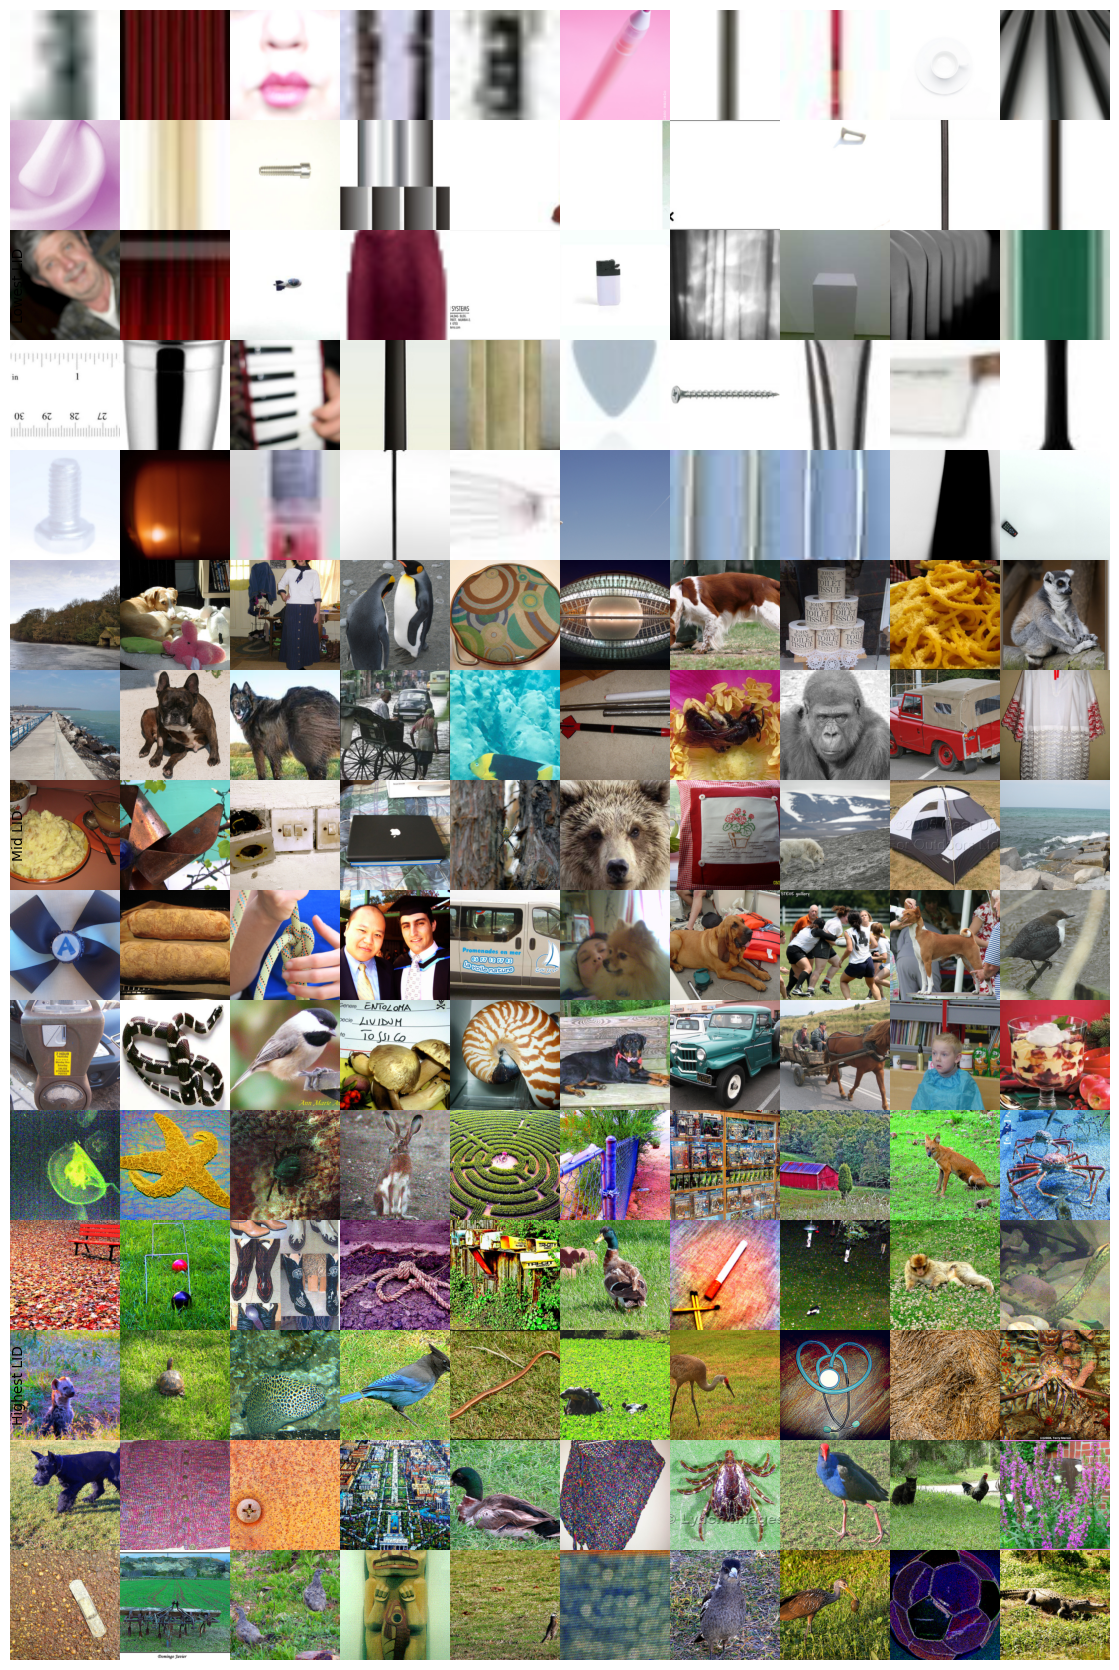

In [10]:
# Compact visualization: remove whitespace and save as PDF
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
n = 50              # images per group
rows, cols = 5, 10  # grid per group
assert rows * cols >= n, "rows*cols must cover n"

# Prepare groups
groups = [
    ("Lowest LID", lowest_indices[:n]),
    ("Mid LID",    mid_indices[:n]),
    ("Highest LID", highest_indices[:n]),
]

H = rows * len(groups)
W = cols
fig_h = 1.1 * H   # figure size scales roughly with tile count
fig_w = 1.1 * W
fig, axs = plt.subplots(H, W, figsize=(fig_w, fig_h))

# Ensure axs is 2D
if H == 1:
    axs = axs[None, :]

# Draw tiles
for gi, (gname, indices) in enumerate(groups):
    for i, idx in enumerate(indices):
        r_local, c = divmod(i, cols)
        r = gi * rows + r_local
        ax = axs[r, c]
        img = imagenet.dataset[idx][0]
        img = denormalize(img).clamp(0, 1).permute(1, 2, 0).cpu()
        ax.imshow(img)
        ax.set_axis_off()

# Remove all spacing and margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Minimal group labels on the left margin without changing layout
for gi, (gname, _) in enumerate(groups):
    y = 1 - (gi + 0.5) / len(groups)
    fig.text(0.002, y, gname, va='center', ha='left', fontsize=10, color='black', rotation=90)

# Save outputs with no padding
out_pdf = Path("lid_grid.pdf")
out_png = Path("lid_grid.png")
fig.savefig(out_pdf, bbox_inches='tight', pad_inches=0, dpi=300)
fig.savefig(out_png, bbox_inches='tight', pad_inches=0, dpi=300)
print(f"Saved {out_pdf} and {out_png}")

plt.show()


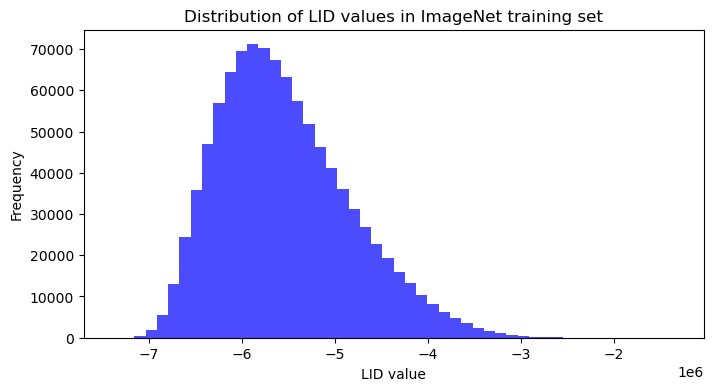

In [4]:
# plot the distribution of LID values
plt.figure(figsize=(8, 4))
plt.hist(all_lids, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of LID values in ImageNet training set')
plt.xlabel('LID value')
plt.ylabel('Frequency')
plt.show()

In [5]:
# since the LID values can be large and may be negative,
# apply a signed log transform first, then compute mean and std.
# Use NumPy arrays (not Python lists) for vectorized math.
lids_np = np.asarray(all_lids, dtype=np.float64)
mean_lid_before_log = float(lids_np.mean())  # ddof=0 (matches np.std default)
std_lid_before_log = float(lids_np.std())
print(f"Mean LID (signed log1p): {mean_lid_before_log:.4f}, Std LID (signed log1p): {std_lid_before_log:.4f}")

lids_log = np.sign(lids_np) * np.log1p(np.abs(lids_np))
mean_lid_after_log = float(lids_log.mean())  # ddof=0 (matches np.std default)
std_lid_after_log = float(lids_log.std())
print(f"Mean LID (signed log1p): {mean_lid_after_log:.4f}, Std LID (signed log1p): {std_lid_after_log:.4f}")

Mean LID (signed log1p): -5541565.5392, Std LID (signed log1p): 708356.6451
Mean LID (signed log1p): -15.5189, Std LID (signed log1p): 0.1364


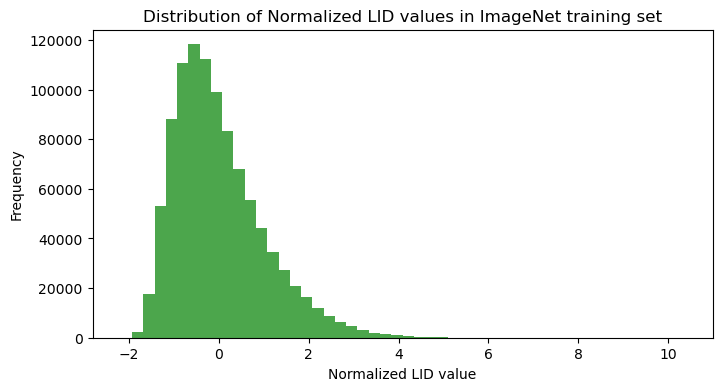

In [7]:
# plot the normalized LID values
lids_normalized_log = (lids_log - mean_lid_after_log) / std_lid_after_log
plt.figure(figsize=(8, 4))
plt.hist(lids_normalized_log, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Normalized LID values in ImageNet training set')
plt.xlabel('Normalized LID value')
plt.ylabel('Frequency')
plt.show()

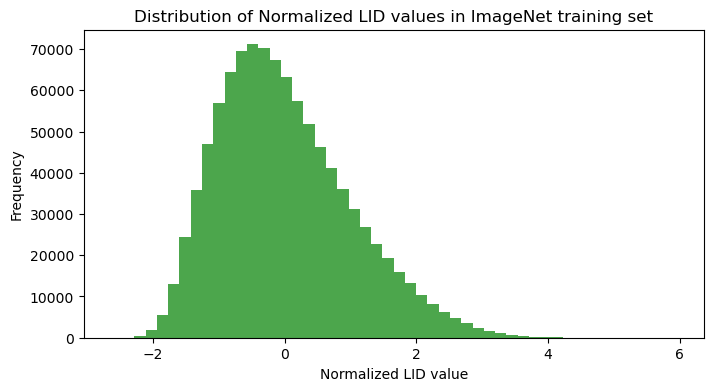

In [8]:
# plot the normalized LID values
lids_normalized = (lids_np - mean_lid_before_log) / std_lid_before_log
plt.figure(figsize=(8, 4))
plt.hist(lids_normalized, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Normalized LID values in ImageNet training set')
plt.xlabel('Normalized LID value')
plt.ylabel('Frequency')
plt.show()